# Logistic Regression model for predicting customer response to telemarketing campaigns for term deposit

# Problem Statement

Output variable -> y

y -> Whether the client has subscribed a term deposit or not 

Binomial ("yes" or "no")


Attribute information For bank dataset

   Input variables:
   
   __bank client data:__

   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   
   5 - default: has credit in default? (binary: "yes","no")
   
   6 - balance: average yearly balance, in euros (numeric) 
   
   7 - housing: has housing loan? (binary: "yes","no")
   
   8 - loan: has personal loan? (binary: "yes","no")
   
   __related with the last contact of the current campaign:__

   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  
  10 - day: last contact day of the month (numeric)
  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  12 - duration: last contact duration, in seconds (numeric)
   
   __other attributes:__
  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [5]:
raw_data = pd.read_csv('bank-full.csv', delimiter = ';')

In [7]:
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Data exploration

In [9]:
raw_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [11]:
raw_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [12]:
raw_data[raw_data.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [13]:
raw_data[raw_data.duplicated()].shape

(0, 17)

In [14]:
numerical_features = raw_data.select_dtypes(include = 'number').columns.tolist()

In [15]:
print(numerical_features)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [16]:
raw_data[numerical_features].head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


In [20]:
discrete_feature = [feature for feature in numerical_features if len(raw_data[feature].unique())<25]
print('Discrete Variables count: {}'.format(len(discrete_feature)))

Discrete Variables count: 0


In [21]:
continous_feature = [feature for feature in numerical_features if feature not in discrete_feature]
print('Continous variable count: {}'.format(len(continous_feature)))

Continous variable count: 7


In [23]:
raw_data.corr(numeric_only = True)

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


<Axes: >

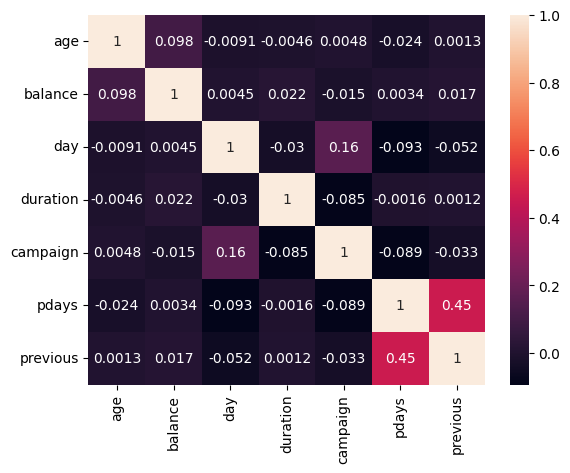

In [24]:
sns.heatmap(raw_data.corr(numeric_only = True), annot = True)

No two columns are quite co-related to each other, excpet pdays and previous has a correlation value of 0.45.

# Exploratory Data Analysis

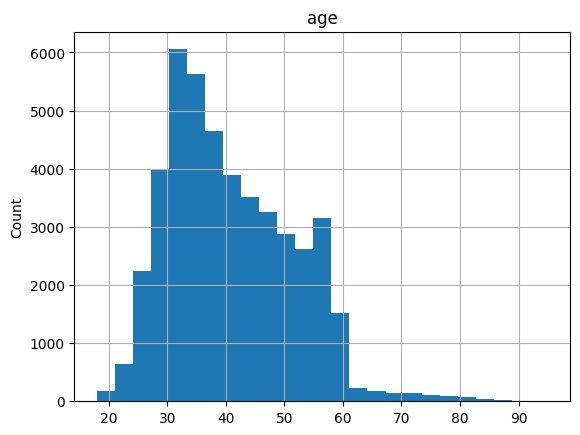

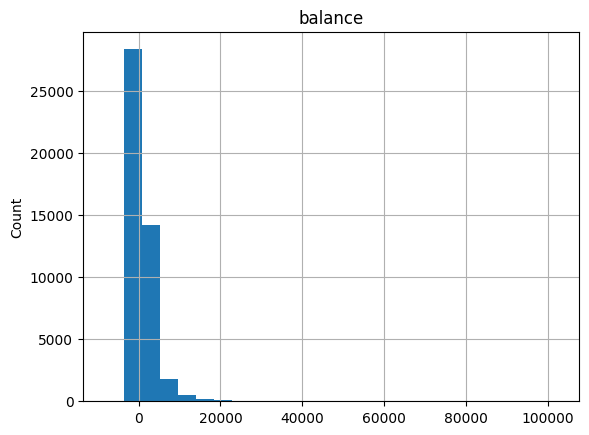

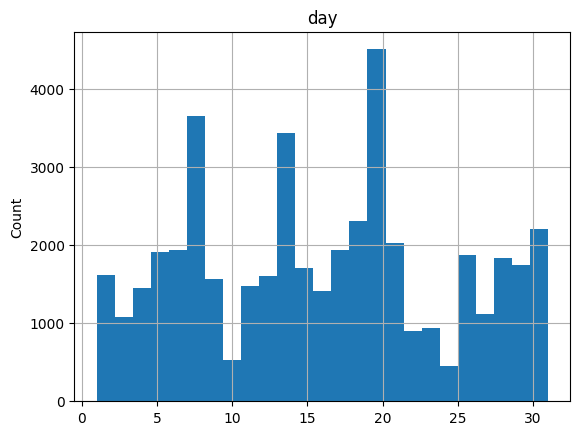

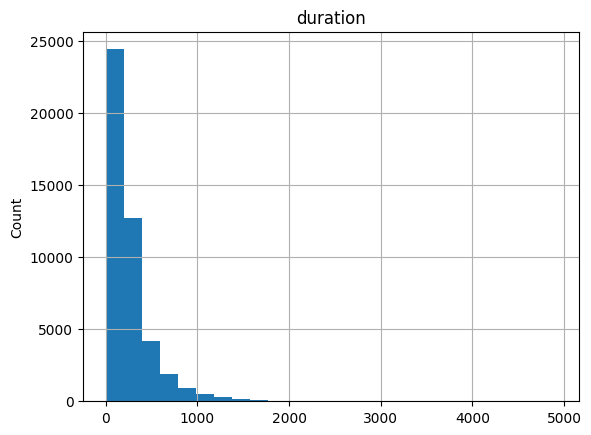

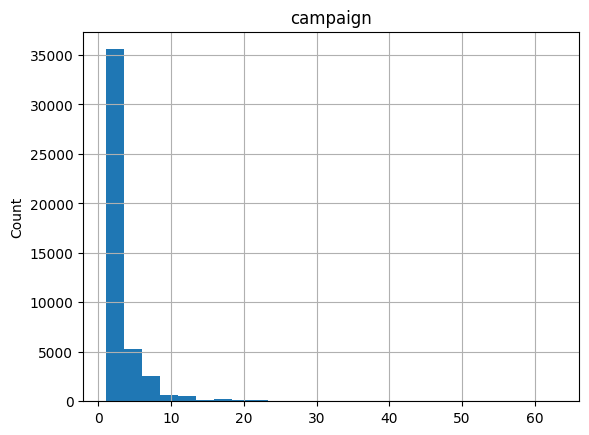

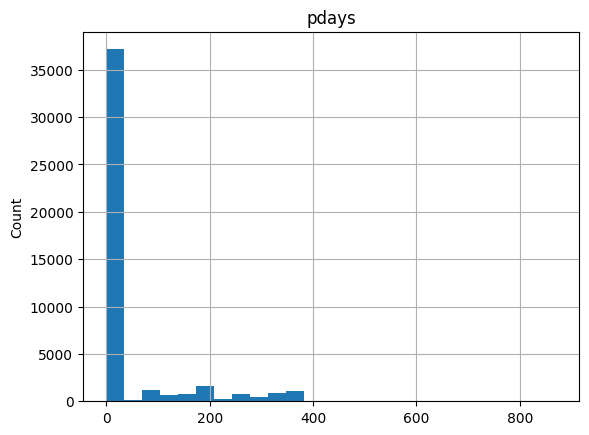

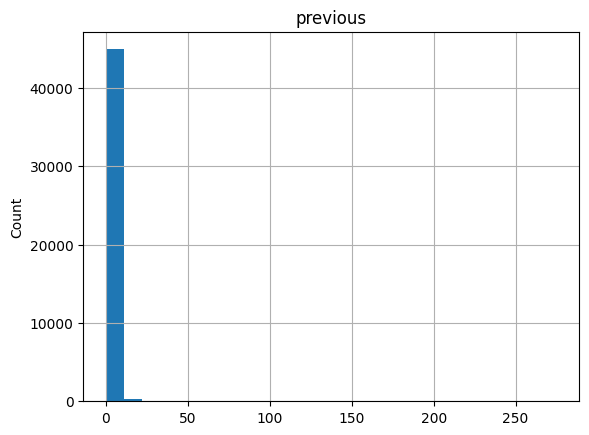

In [25]:
data = raw_data.copy()
for feature in continous_feature:
    data[feature].hist(bins = 25)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

# Log transforamtion

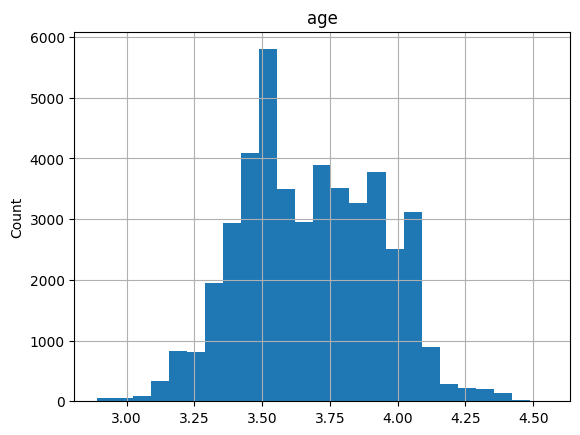

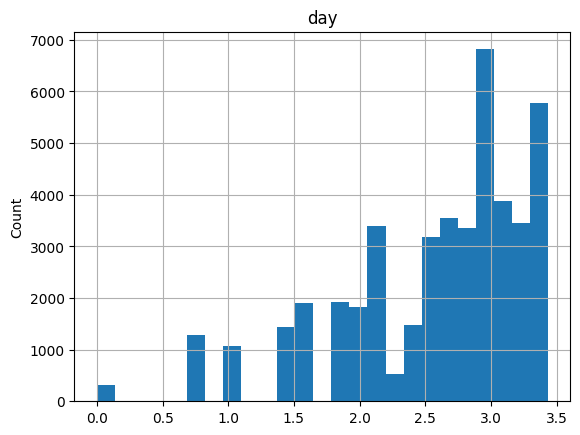

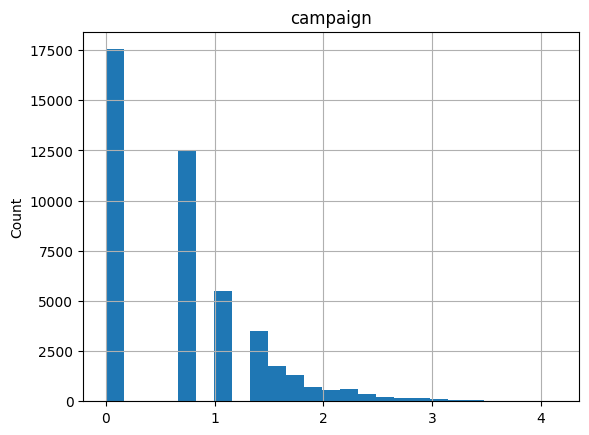

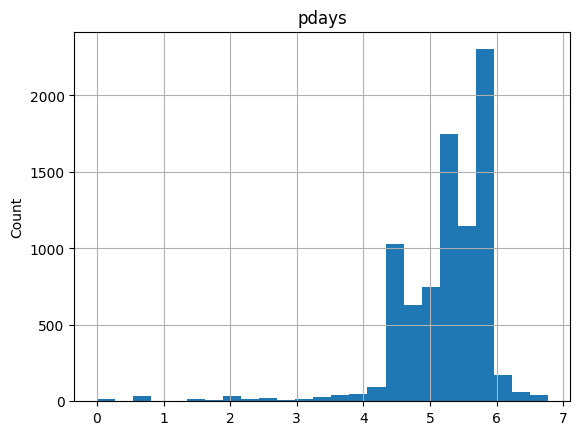

In [26]:
for feature in continous_feature:
    if 0 in data[feature].unique():
        pass
    else:
        data[feature] = np.log(data[feature])
        data[feature].hist(bins = 25)
        plt.ylabel('Count')
        plt.title(feature)
        plt.show()

## Outliers Detection

In [27]:
data = raw_data.copy()

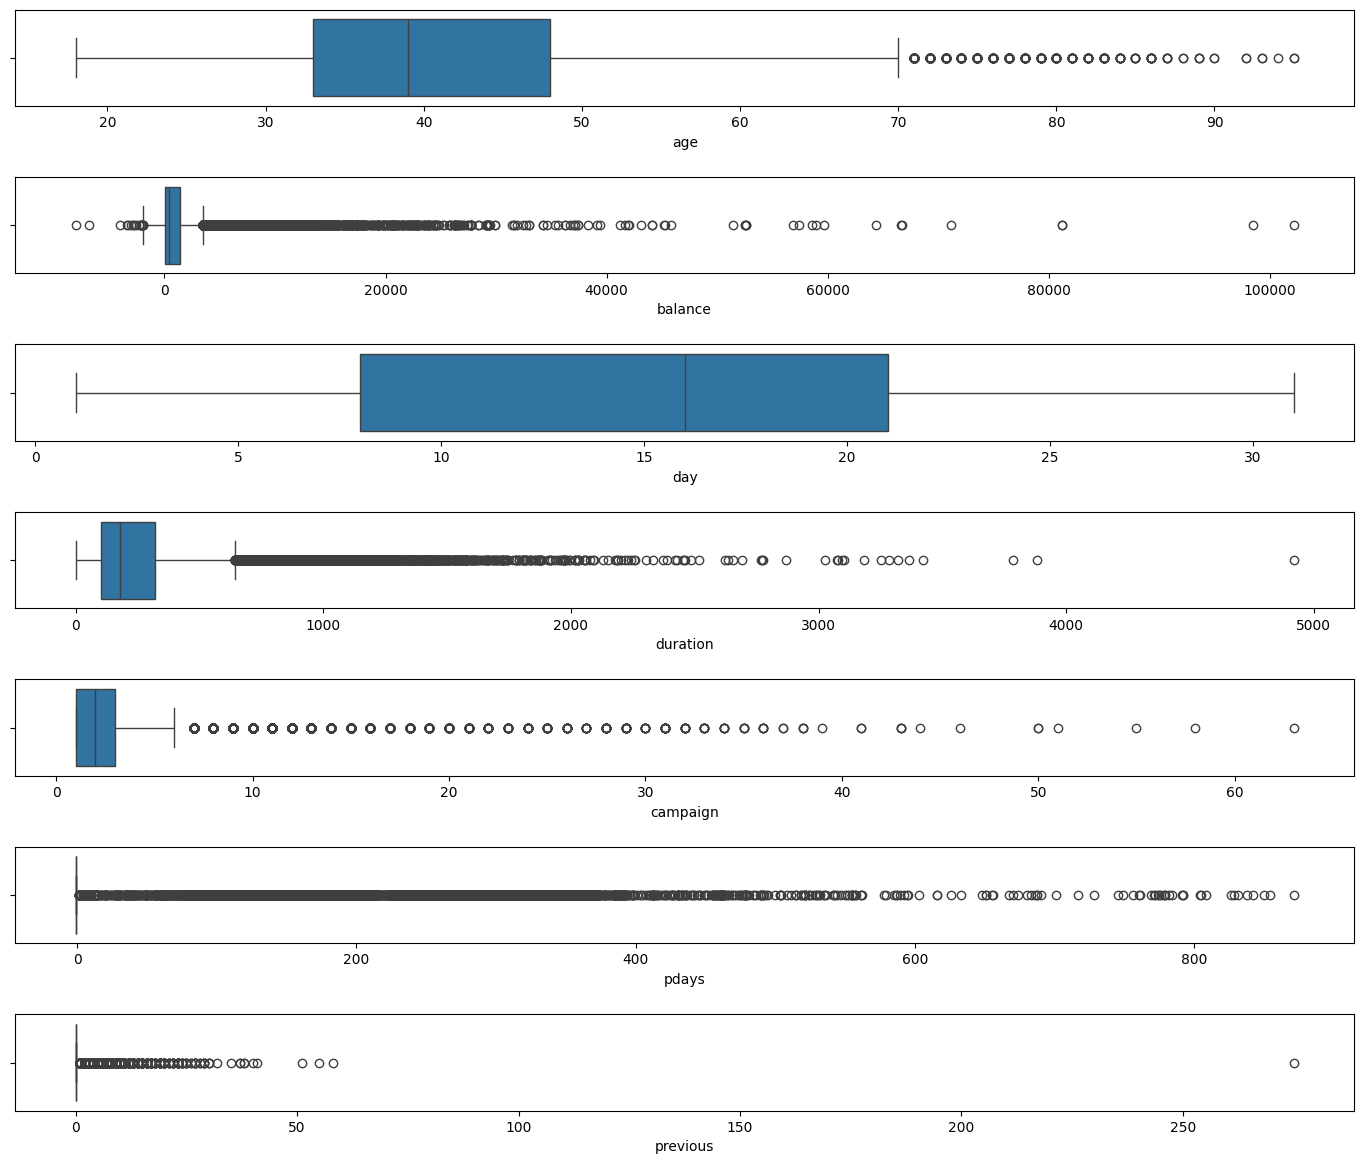

In [29]:
fig, axes = plt.subplots(7,1, figsize = (14, 12), sharex = False, sharey = False)
i = 0
for var in continous_feature:
    sns.boxplot(x = var, data = data, ax = axes[i])
    i += 1
plt.tight_layout(pad = 2.0)

Only feature 'day' doesnt have any outlier, otherwise all the features have outliers. So, let's see what how we can go about it.

In [31]:
data[continous_feature] = np.log(data[continous_feature])

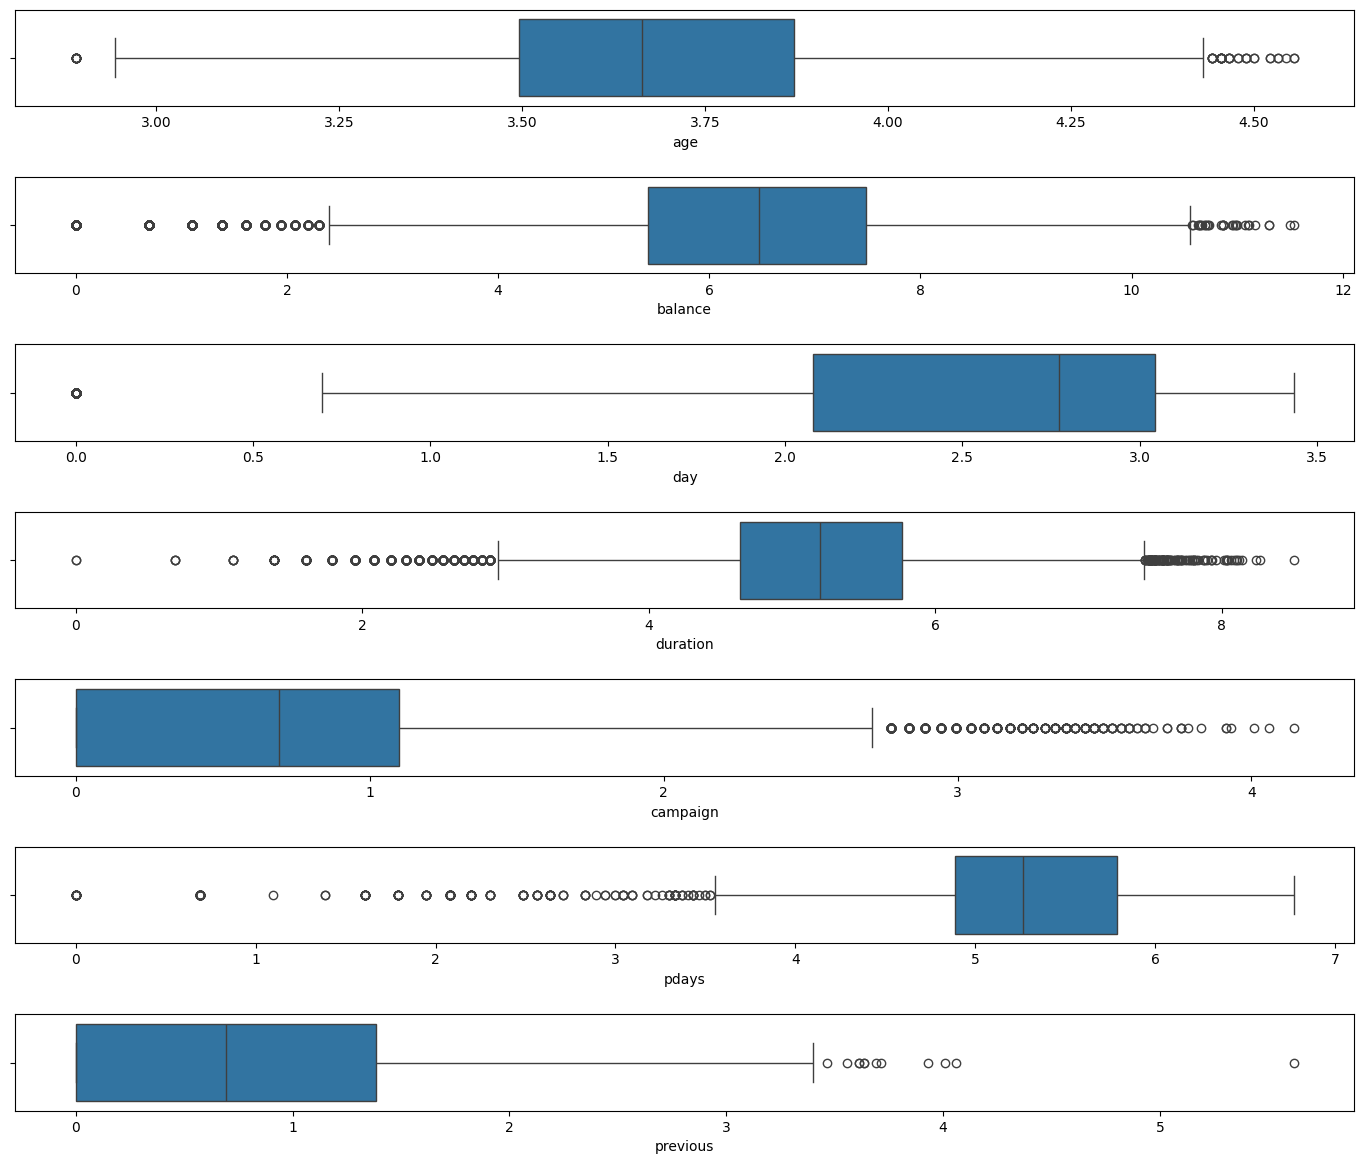

In [32]:
fig, axes = plt.subplots(7,1, figsize = (14, 12), sharex = False, sharey = False)
i = 0
for var in continous_feature:
    sns.boxplot(x = var, data = data, ax = axes[i])
    i += 1
plt.tight_layout(pad = 2.0)

Outliers are significantly reduced. We can use this dataset for our analysis too.

## Visualize the distribution of age and balance

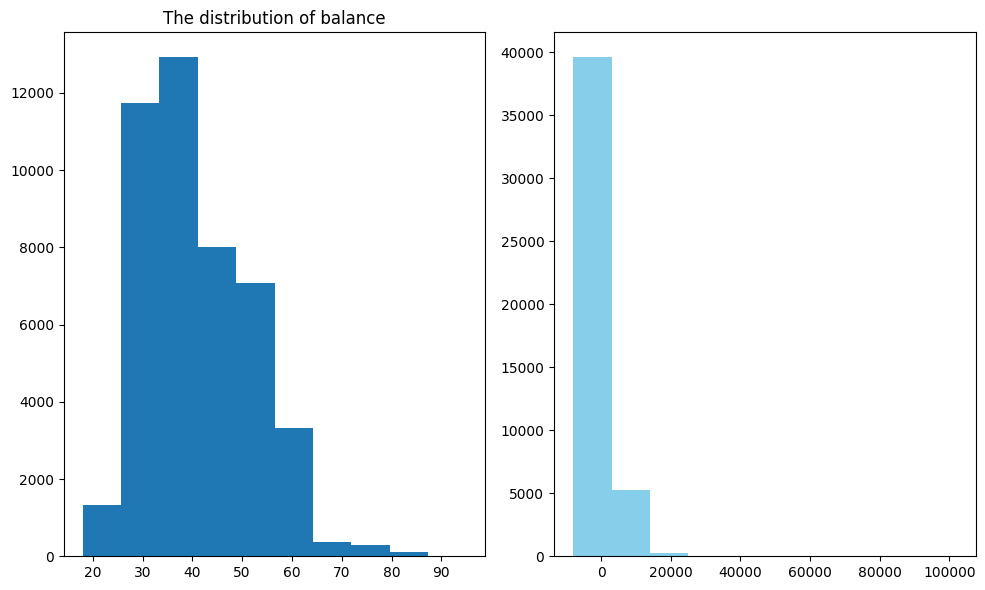

In [36]:
dist_age_balance = plt.figure(figsize = (10, 6))

ra1 = dist_age_balance.add_subplot(1,2,1)
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(raw_data['age'])
ra1.set_title('The distribution of age')

ra2.hist(raw_data['balance'], color = 'skyblue')
ra1.set_title('The distribution of balance')

plt.tight_layout()
plt.show()

In [37]:
raw_data[['age','balance']].describe()

,age,balance
count,45211.000000,45211.000000
mean,40.936210,1362.272058
std,10.618762,3044.765829
min,18.000000,-8019.000000
25%,33.000000,72.000000
50%,39.000000,448.000000
75%,48.000000,1428.000000
max,95.000000,102127.000000


## Visualize the relationship between duration and campaign

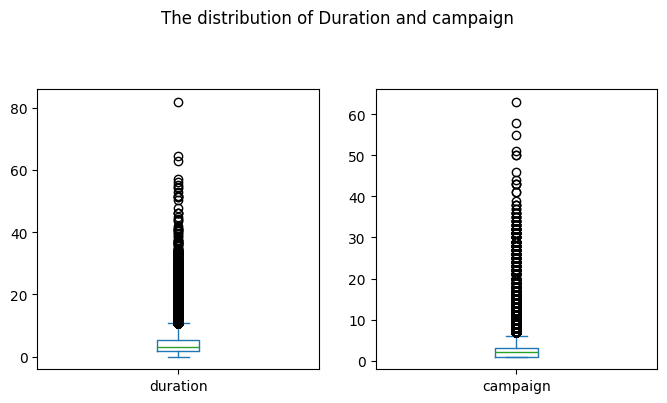

In [39]:
df = raw_data.copy()
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)
df[['duration', 'campaign']].plot(kind = 'box',
                                  figsize = (8, 8),
                                  subplots = True, layout = (2,2),
                                  sharex = False, sharey = False,
                                  title = 'The distribution of Duration and campaign') 
plt.show()

In [41]:
df[['duration', 'campaign']].describe()

,duration,campaign
count,45211.000000,45211.000000
mean,4.302729,2.763841
std,4.292132,3.098021
min,0.000000,1.000000
25%,1.720000,1.000000
50%,3.000000,2.000000
75%,5.320000,3.000000
max,81.970000,63.000000


## Now let's look how numerical columns affect term deposit subscription

           age_yes        age_no
count  5289.000000  39922.000000
mean     41.670070     40.838986
std      13.497781     10.172662
min      18.000000     18.000000
25%      31.000000     33.000000
50%      38.000000     39.000000
75%      50.000000     48.000000
max      95.000000     95.000000


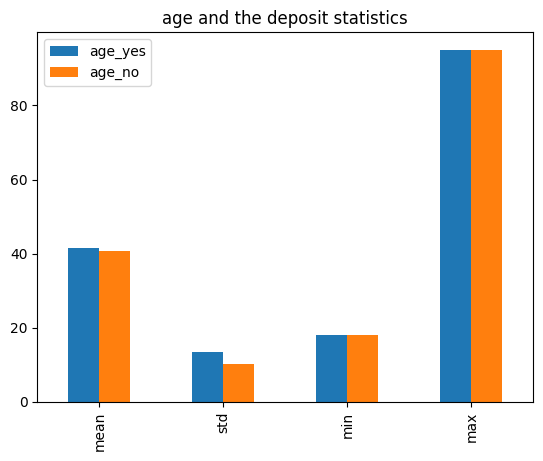

        balance_yes     balance_no
count   5289.000000   39922.000000
mean    1804.267915    1303.714969
std     3501.104777    2974.195473
min    -3058.000000   -8019.000000
25%      210.000000      58.000000
50%      733.000000     417.000000
75%     2159.000000    1345.000000
max    81204.000000  102127.000000


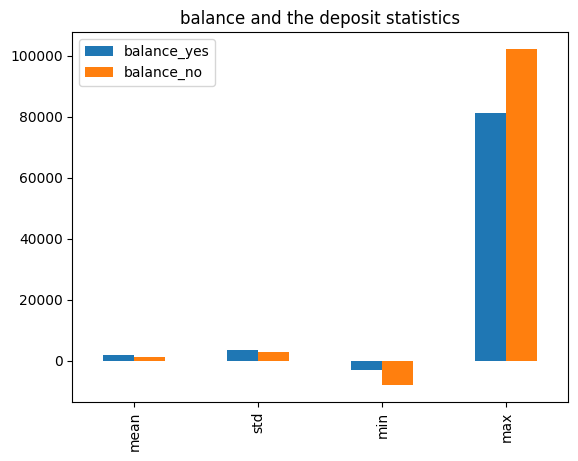

           day_yes        day_no
count  5289.000000  39922.000000
mean     15.158253     15.892290
std       8.501875      8.294728
min       1.000000      1.000000
25%       8.000000      8.000000
50%      15.000000     16.000000
75%      22.000000     21.000000
max      31.000000     31.000000


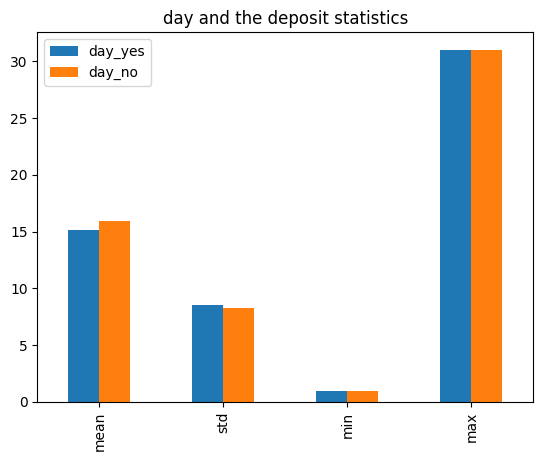

       duration_yes   duration_no
count   5289.000000  39922.000000
mean     537.294574    221.182806
std      392.525262    207.383237
min        8.000000      0.000000
25%      244.000000     95.000000
50%      426.000000    164.000000
75%      725.000000    279.000000
max     3881.000000   4918.000000


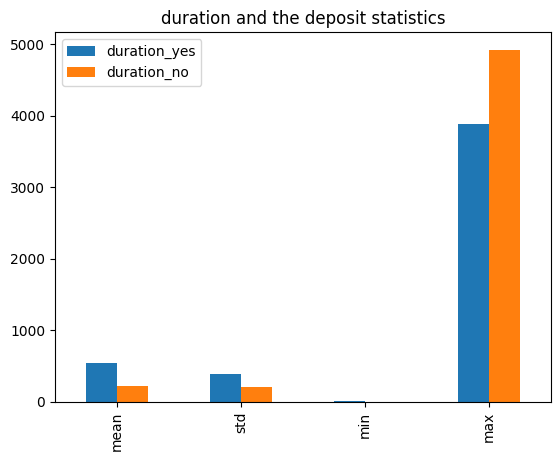

       campaign_yes   campaign_no
count   5289.000000  39922.000000
mean       2.141047      2.846350
std        1.921826      3.212767
min        1.000000      1.000000
25%        1.000000      1.000000
50%        2.000000      2.000000
75%        3.000000      3.000000
max       32.000000     63.000000


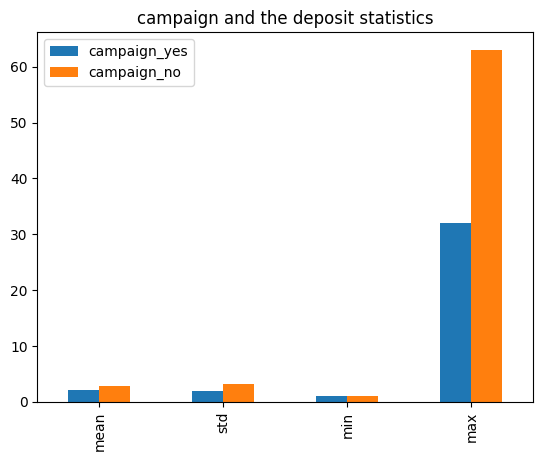

         pdays_yes      pdays_no
count  5289.000000  39922.000000
mean     68.702968     36.421372
std     118.822266     96.757135
min      -1.000000     -1.000000
25%      -1.000000     -1.000000
50%      -1.000000     -1.000000
75%      98.000000     -1.000000
max     854.000000    871.000000


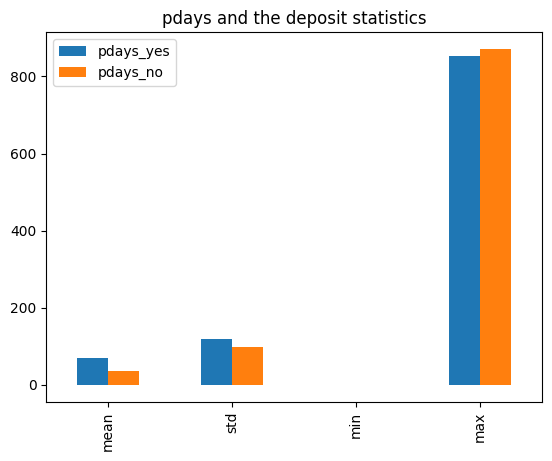

       previous_yes   previous_no
count   5289.000000  39922.000000
mean       1.170354      0.502154
std        2.553272      2.256771
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        1.000000      0.000000
max       58.000000    275.000000


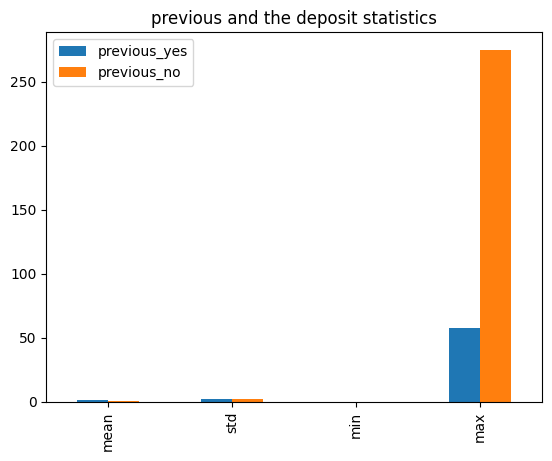

In [51]:
for var in continous_feature:
    df_n = pd.DataFrame()
    yes = var + '_yes'
    no = var + '_no'
    df_n[yes] = (raw_data[raw_data['y'] == 'yes'][['y', var]].describe())
    df_n[no] = (raw_data[raw_data['y'] == 'no'][['y', var]].describe())
    print(df_n)
    title = var + ' and the deposit statistics'
    df_n.drop(['count','25%','50%','75%']).plot.bar(title = title)
    plt.show()

## Categorical variables

In [55]:
categorical_features = [feature for feature in raw_data.columns if feature not in numerical_features]
print('Number of categorical features: ', len(categorical_features), '\n', categorical_features)

Number of categorical features:  10 
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [56]:
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [58]:
for feature in categorical_features:
    unique_cat = len(raw_data[feature].unique())
    print('Feature {} has {} unique categories'.format(feature, unique_cat))
    print(raw_data[feature].value_counts())
    print()

Feature job has 12 unique categories
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

Feature marital has 3 unique categories
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

Feature education has 4 unique categories
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

Feature default has 2 unique categories
default
no     44396
yes      815
Name: count, dtype: int64

Feature housing has 2 unique categories
housing
yes    25130
no     20081
Name: count, dtype: int64

Feature loan has 2 unique categories
loan
no     37967
yes     7244
Name: count, dtype: int64

Feature contact has 3 unique categories
contact
cellular     29285
unknown      13020
t

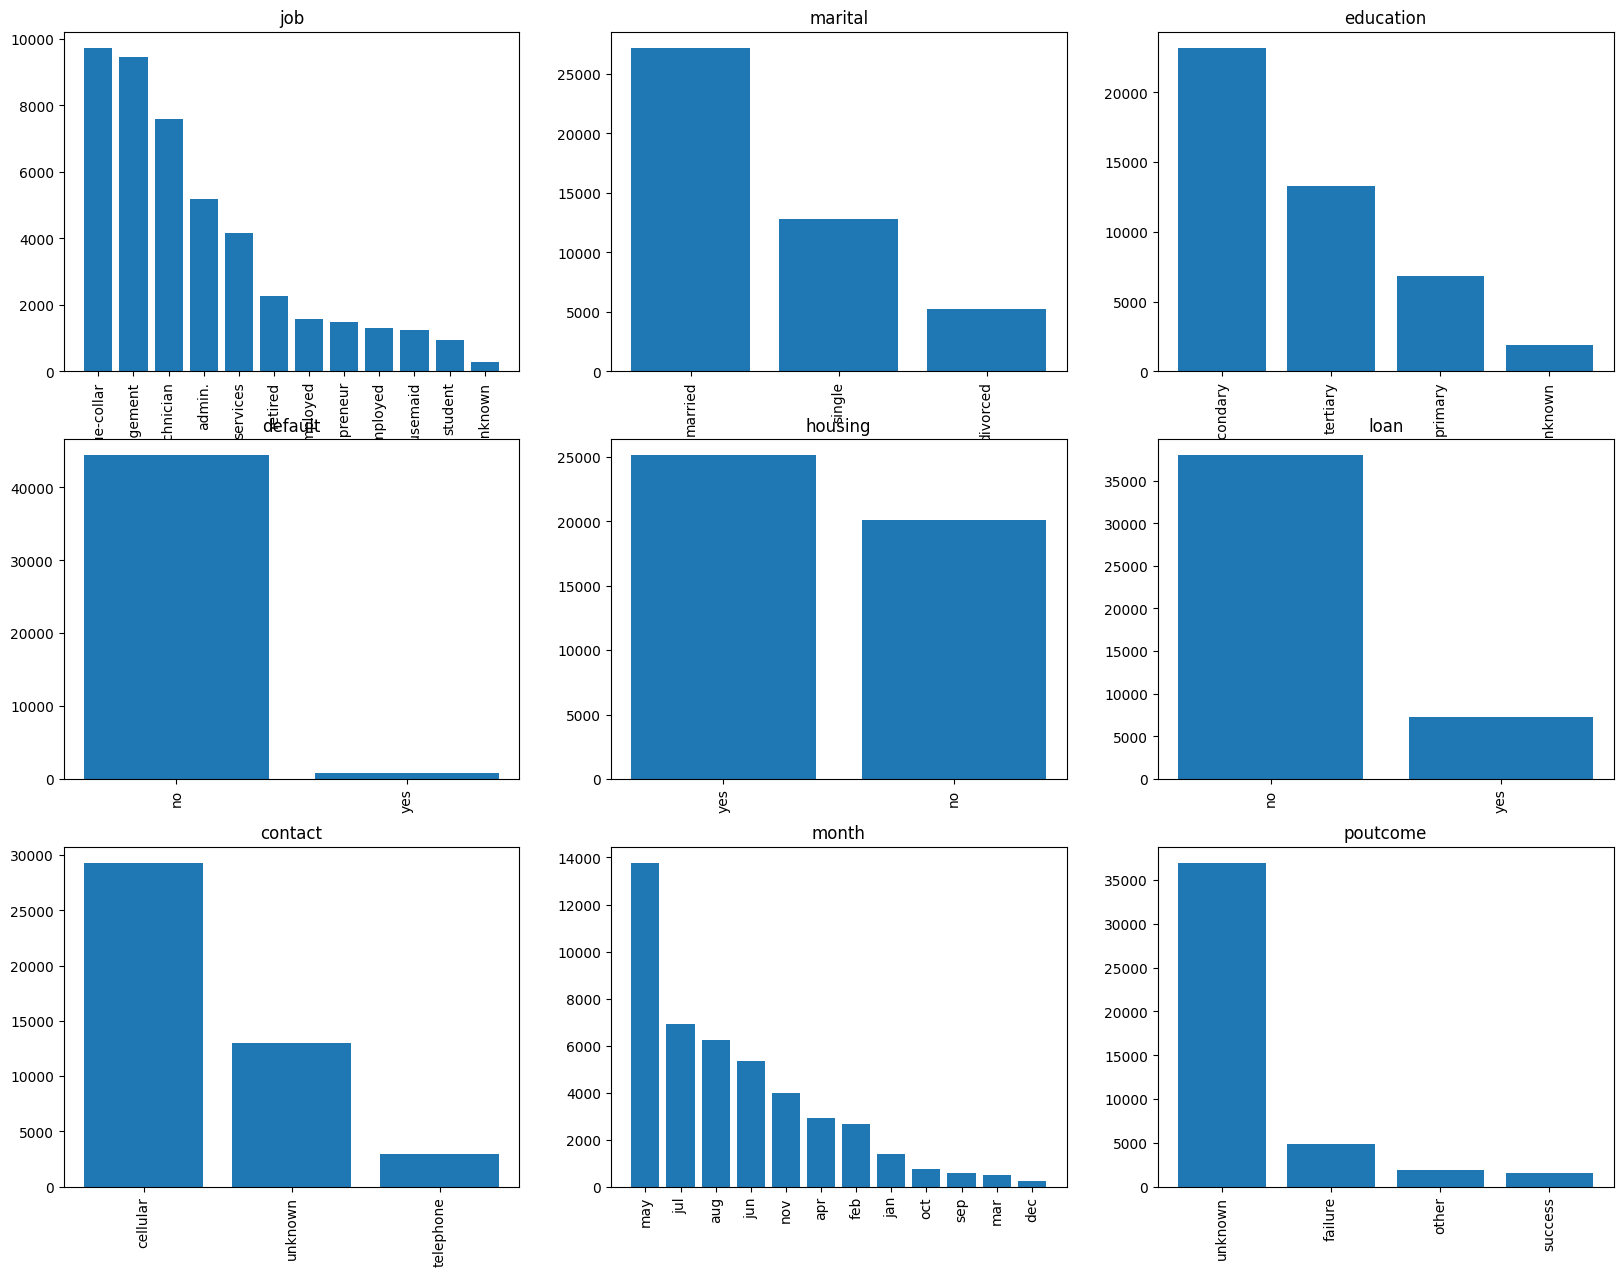

In [61]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = raw_data[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

## Analysising the target set

In [63]:
nd = len(raw_data[raw_data.y == 'no'])
yd = len(raw_data[raw_data.y == 'yes'])

print('Percentage of customer doesnt have a term deposit: {:.2f}%'.format((nd/len(raw_data.y))*100))
print('Percentage of customer does have a term deposit: {:.2f}%'.format((yd/len(raw_data.y))*100))

Percentage of customer doesnt have a term deposit: 88.30%
Percentage of customer does have a term deposit: 11.70%


In [64]:
raw_data.y.value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

Text(0.5, 1.0, 'Whether the client has subscribed a term deposit or not')

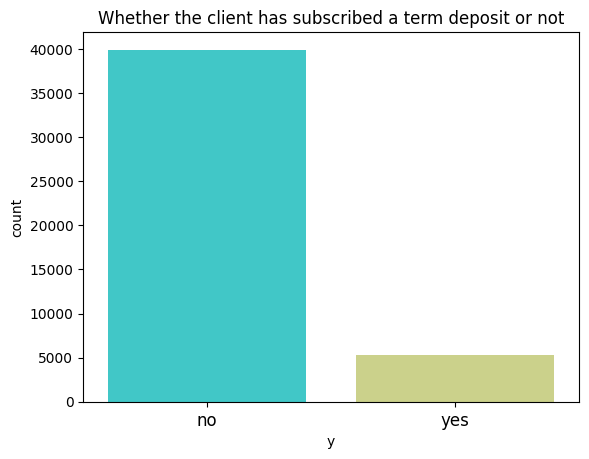

In [67]:
sns.countplot(x = 'y', data= raw_data, 
              order = raw_data['y'].value_counts().index,
             palette = 'rainbow')
plt.xticks(fontsize = 12)
plt.title('Whether the client has subscribed a term deposit or not')

So, the data is imbalance we would be needing to balance it using SMOTE technique

# Data Visualisation

## Univariate analysis

In [74]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']
print(cat_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


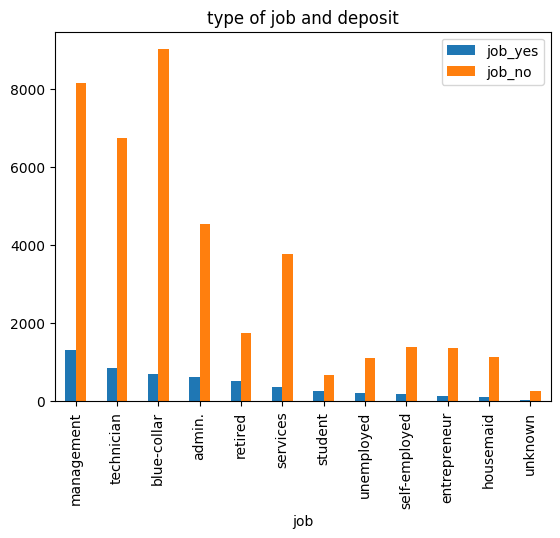

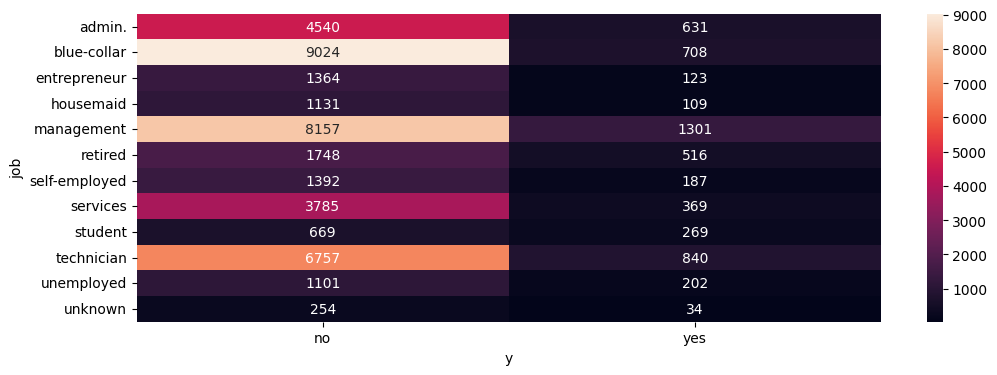

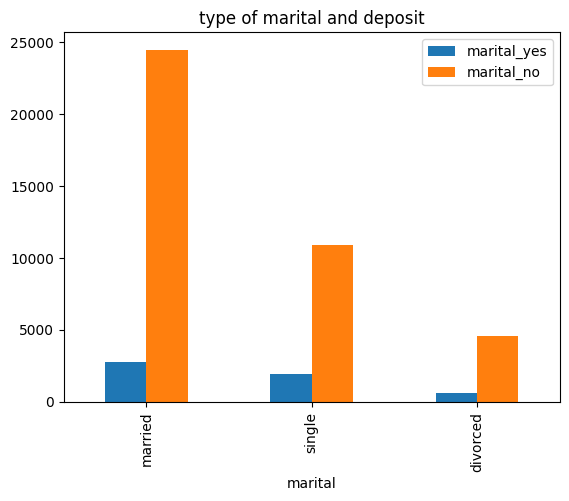

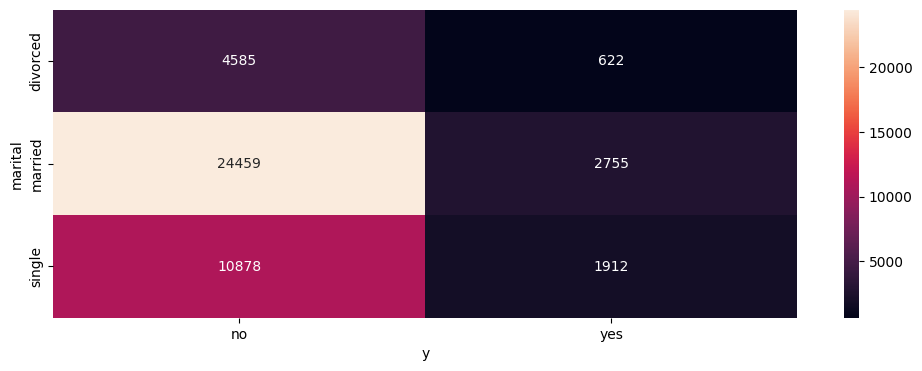

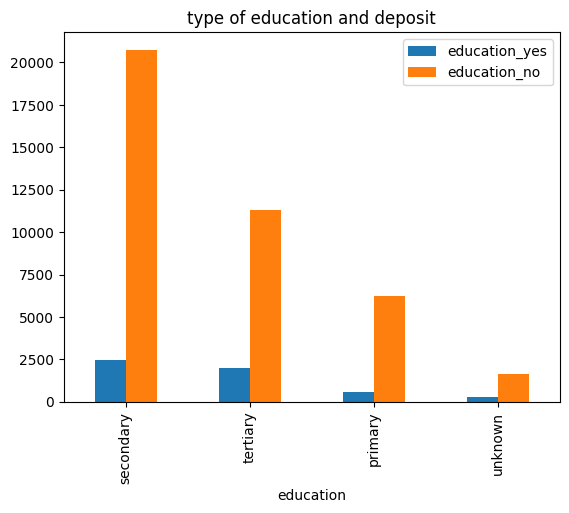

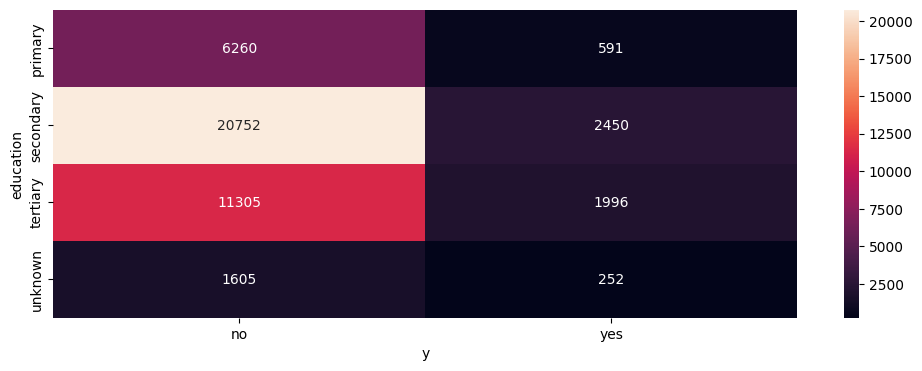

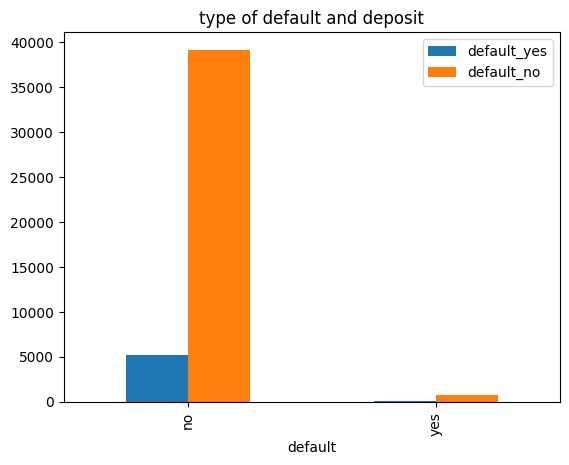

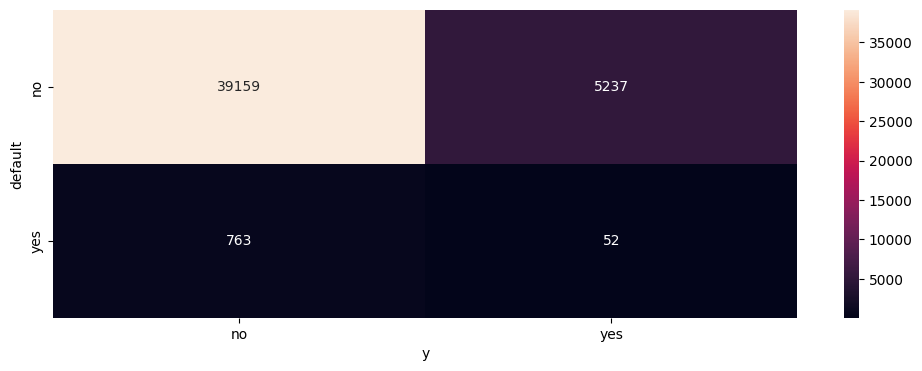

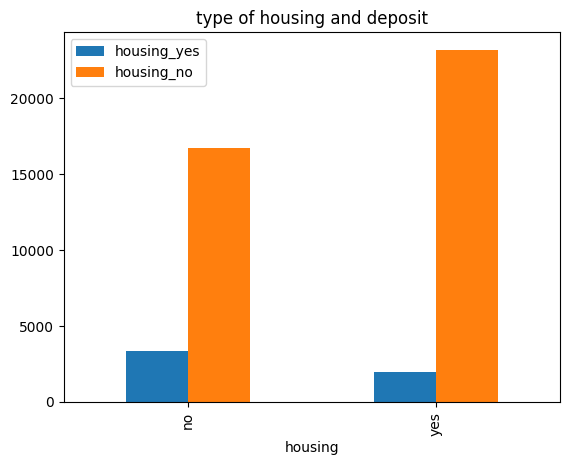

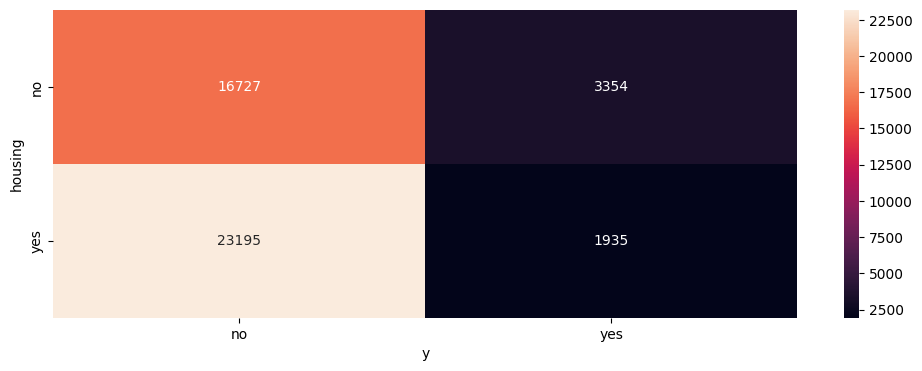

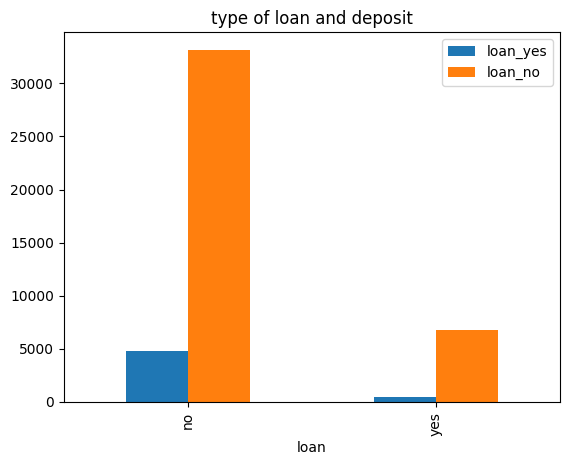

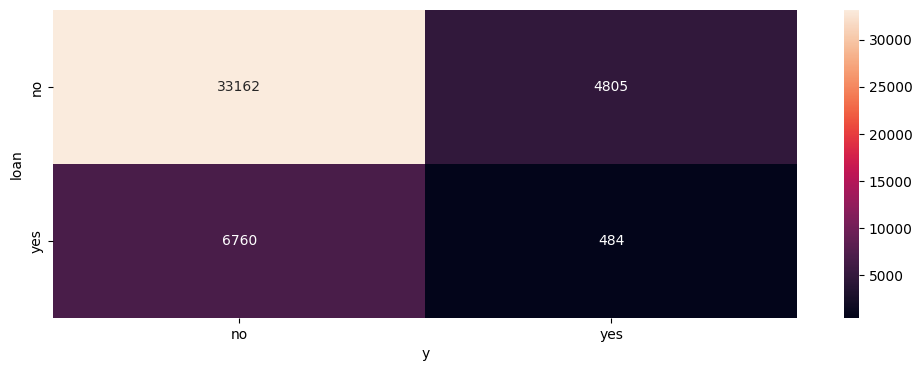

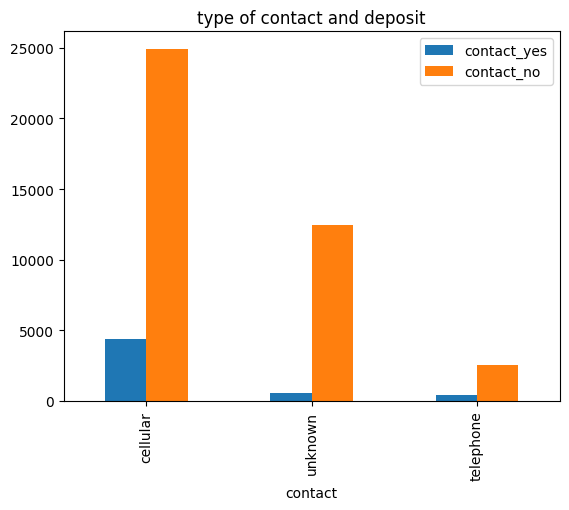

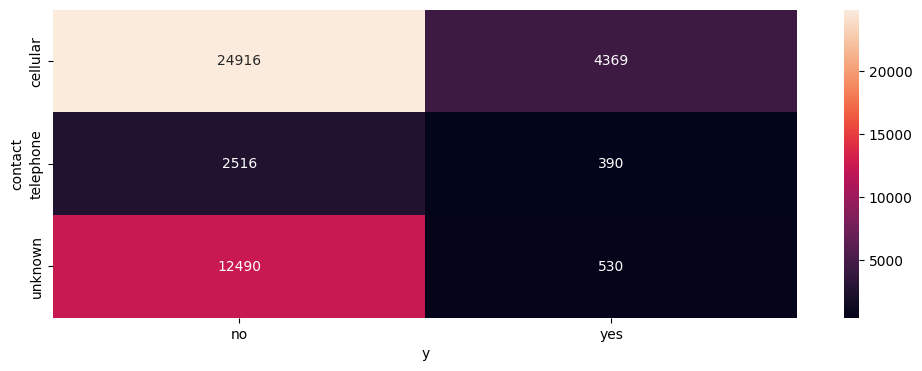

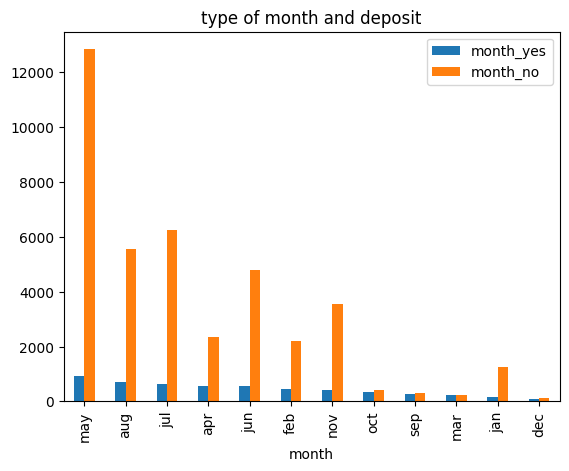

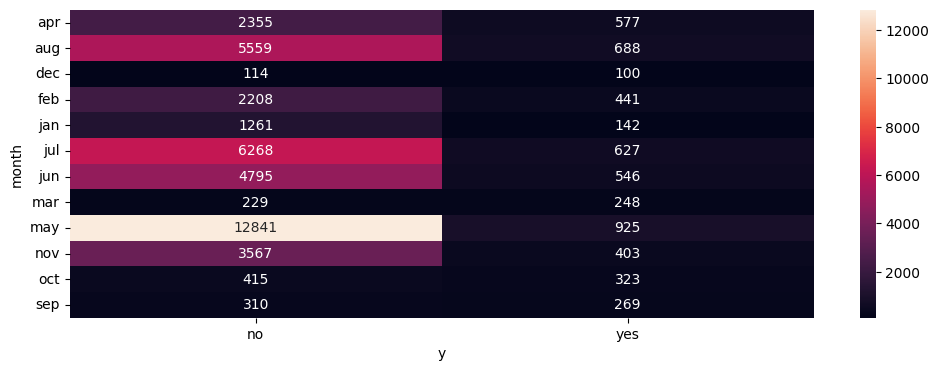

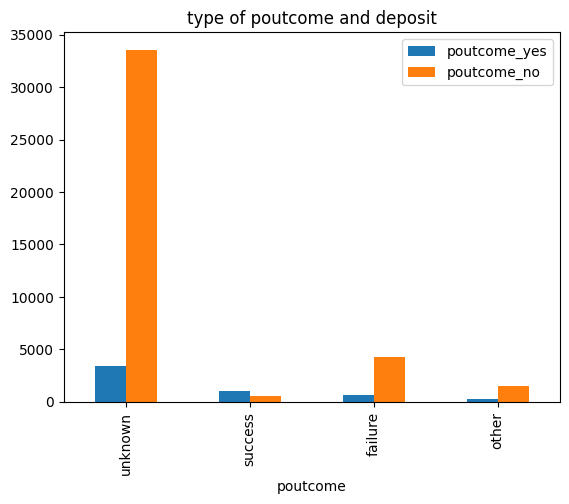

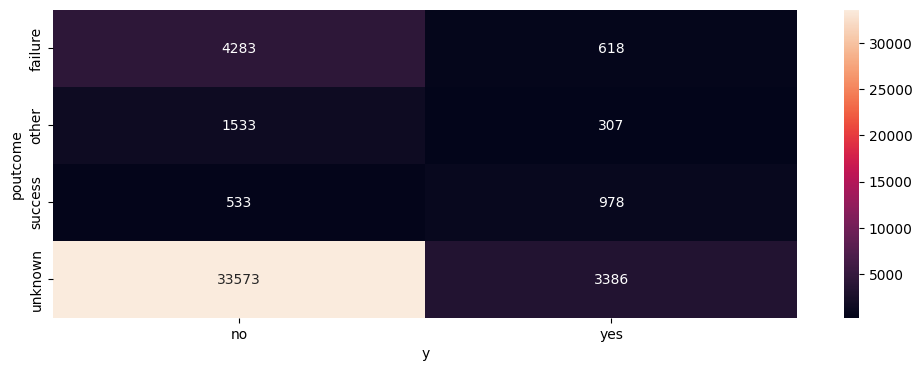

In [77]:
for var in cat_columns:
    df_n = pd.DataFrame()
    yes = var + '_yes'
    no = var + '_no'
    df_n[yes] = raw_data[raw_data['y'] == 'yes'][var].value_counts()
    df_n[no] = raw_data[raw_data['y'] == 'no'][var].value_counts()
    df_n.plot.bar(title = 'type of ' + var +' and deposit')
    plt.show()

    fig= plt.figure(figsize=(12, 4))
    sns.heatmap(pd.crosstab(index=raw_data[var], columns=raw_data['y']), annot=True, 
            fmt='g')

## Bivariate analysis: continous features v/s target

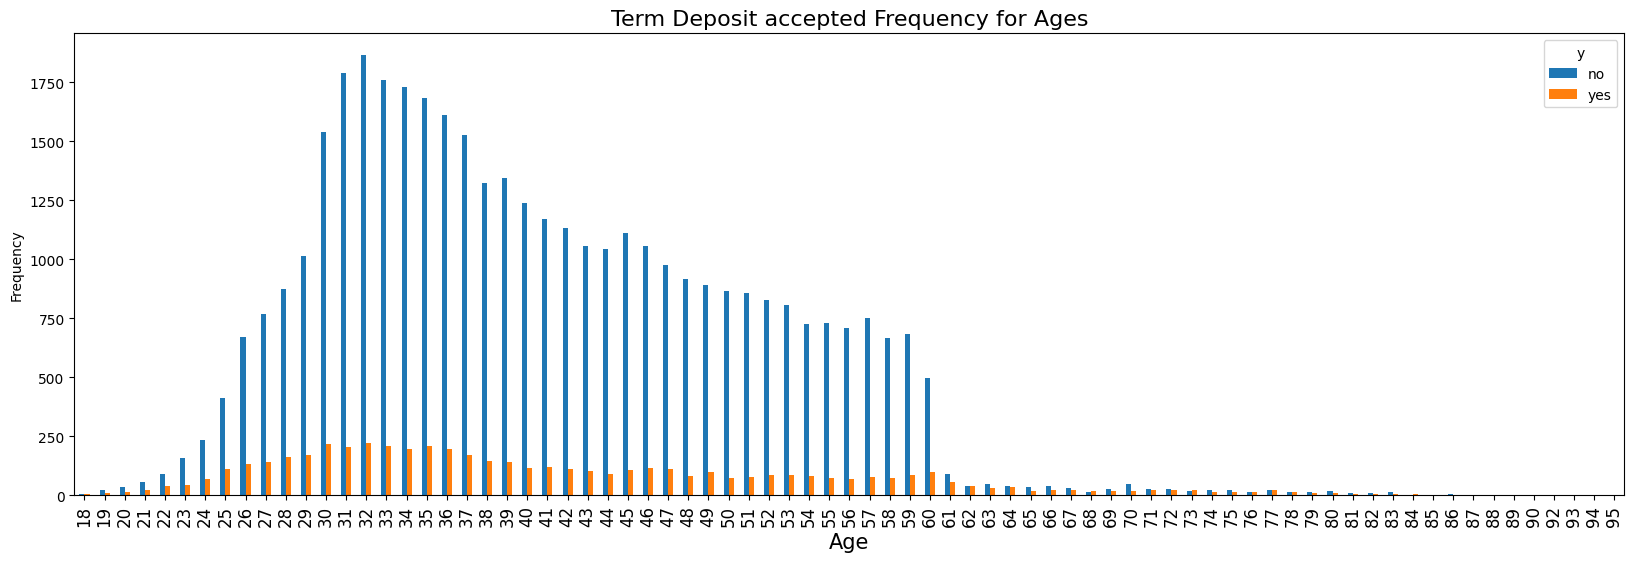

In [81]:
pd.crosstab(raw_data.age,raw_data.y).plot(kind="bar",figsize=(20,6))
plt.title('Term Deposit accepted Frequency for Ages', fontsize = 16)
plt.xticks(fontsize = 12)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Frequency')
plt.show()

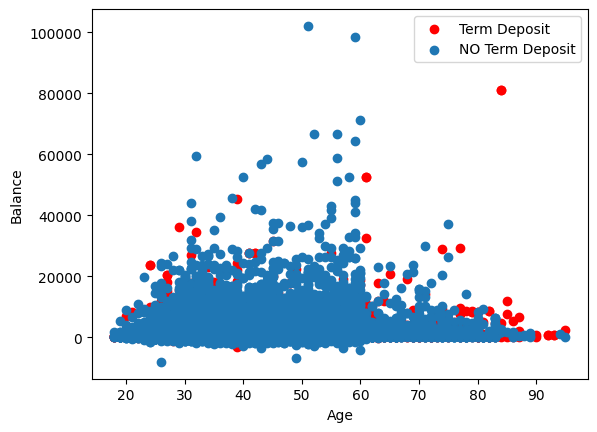

In [82]:
plt.scatter(x=raw_data.age[raw_data.y== 'yes'], y=raw_data.balance[(raw_data.y== 'yes')], c="red")
plt.scatter(x=raw_data.age[raw_data.y== 'no'], y=raw_data.balance[(raw_data.y== 'no')])
plt.legend(["Term Deposit", "NO Term Deposit"])
plt.xlabel("Age")
plt.ylabel("Balance")
plt.show()

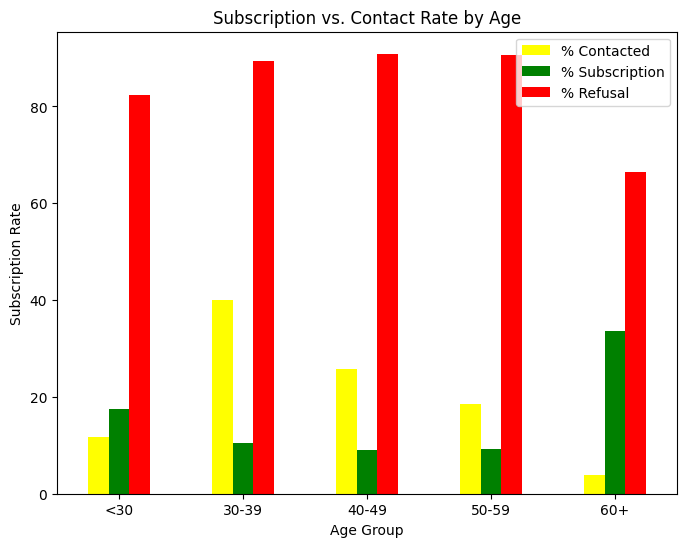

In [96]:
lst = [raw_data]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60
    
count_age_response_pct = pd.crosstab(raw_data['y'],raw_data['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 

age = pd.DataFrame(raw_data['age_group'].value_counts())
age['% Subscription'] = count_age_response_pct['yes']
age['% Refusal'] = count_age_response_pct['no']
age.reset_index(inplace = True)
age['% Contacted'] = age['count']*100/age['count'].sum()
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

plot_age = age[['% Contacted','% Subscription','% Refusal']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('yellow','green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

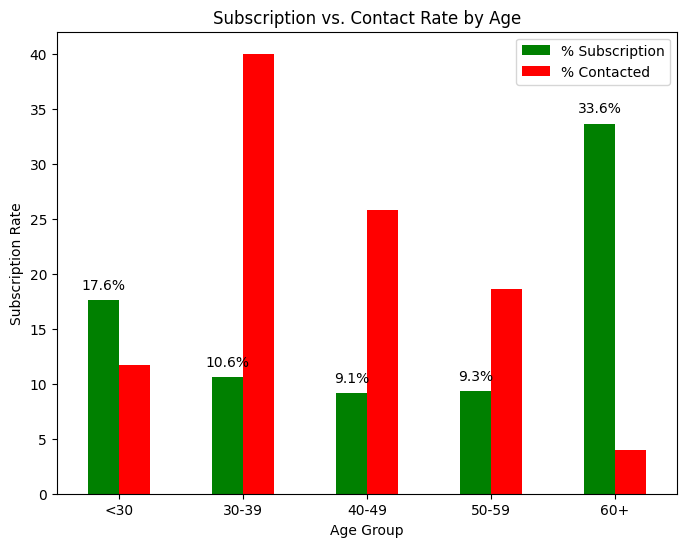

In [97]:
lst = [raw_data]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60
    
count_age_response_pct = pd.crosstab(raw_data['y'],raw_data['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 

age = pd.DataFrame(raw_data['age_group'].value_counts())
age['% Subscription'] = count_age_response_pct['yes']
age.reset_index(inplace = True)
age['% Contacted'] = age['count']*100/age['count'].sum()
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')

# label the bar
for rec, label in zip(plot_age.patches,
                      age['% Subscription'].round(1).astype(str)):
    plot_age.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

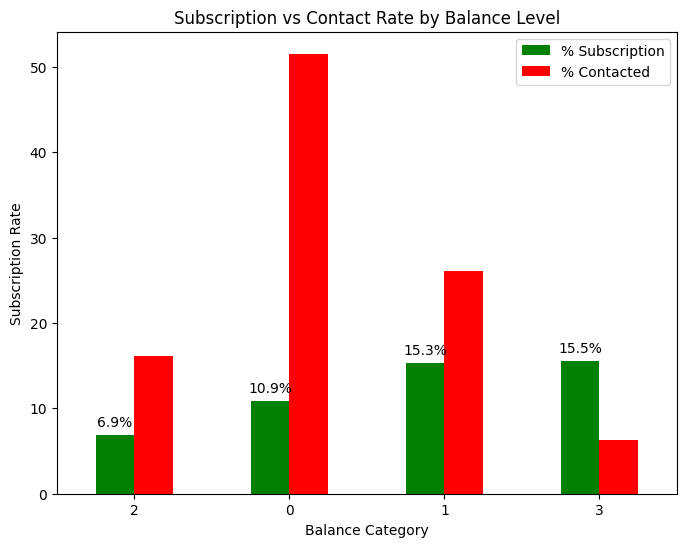

In [98]:
lst = [raw_data]
for column in lst:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 1000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 1000) & (column["balance"] <= 5000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 5000), 'balance_group'] = 'high balance'
    
count_balance_response_pct = pd.crosstab(raw_data['y'],raw_data['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()

bal = pd.DataFrame(raw_data['balance_group'].value_counts())
bal['% Subscription'] = count_balance_response_pct['yes']
bal.reset_index(inplace = True)
bal['% Contacted'] = bal['count']*100/bal['count'].sum()
bal.drop('balance_group',axis = 1,inplace = True)

bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)

plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                               color = ('green','red'),
                                               figsize = (8,6))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

In [100]:
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,balance_group
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,50.0,average balance
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,40.0,low balance
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,30.0,low balance
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,40.0,average balance
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,30.0,low balance


## Visualise the subscription rate by age and balance

In [101]:
df = raw_data.copy()
df.rename(index = str, columns = {'y':'response'}, inplace = True)

def convert(data, new_column, old_column):
    data[new_column] = data[old_column].apply(lambda x:0 if x == 'no' else 1)
    return data[new_column].value_counts()

convert(df, 'response_binary', 'response')

response_binary
0    39922
1     5289
Name: count, dtype: int64

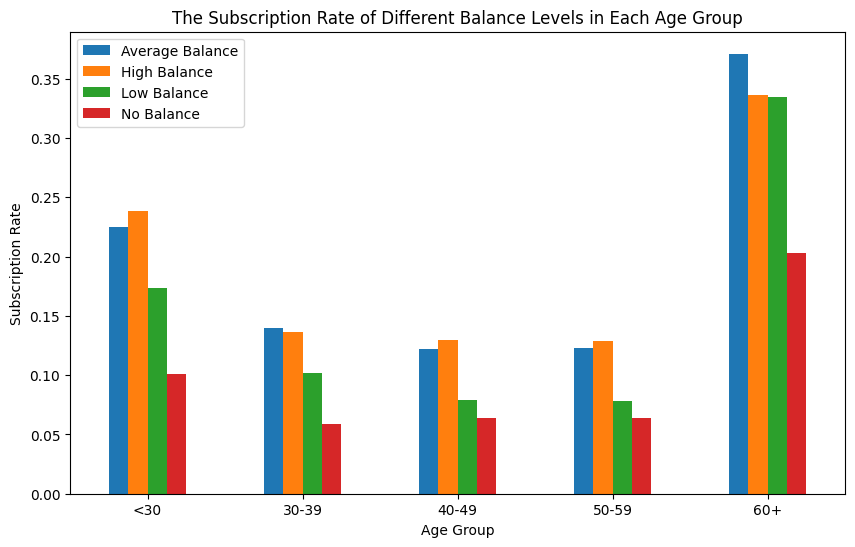

In [102]:
age_balance1 = pd.DataFrame(df.groupby(['age_group','balance_group'])['response_binary'].sum())
age_balance2 = pd.DataFrame(df.groupby(['age_group','balance_group'])['response'].count())

age_balance1['response'] = age_balance2['response']
age_balance1['response_rate'] = age_balance1['response_binary']/ (age_balance1['response'])
age_balance1 = age_balance1.drop(['response_binary','response'],axis =1)

age_balance1 = age_balance1.unstack()
age_bal = age_balance1.plot(kind='bar',figsize = (10,6))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

Targeting older clients with high balance levels would yield better results

# Visualise the subscription by job

In [103]:
count_job_response_pct = pd.crosstab(df['response'],df['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
response,,,,,,,,,,,,
no,87.797331,92.725031,91.728312,91.209677,86.244449,77.208481,88.157061,91.116996,71.321962,88.943004,84.497314,88.194444
yes,12.202669,7.274969,8.271688,8.790323,13.755551,22.791519,11.842939,8.883004,28.678038,11.056996,15.502686,11.805556


In [104]:
count_job_response_pct = count_job_response_pct.transpose()
count_job_response_pct

response,no,yes
job,,
admin.,87.797331,12.202669
blue-collar,92.725031,7.274969
entrepreneur,91.728312,8.271688
housemaid,91.209677,8.790323
management,86.244449,13.755551
retired,77.208481,22.791519
self-employed,88.157061,11.842939
services,91.116996,8.883004
student,71.321962,28.678038


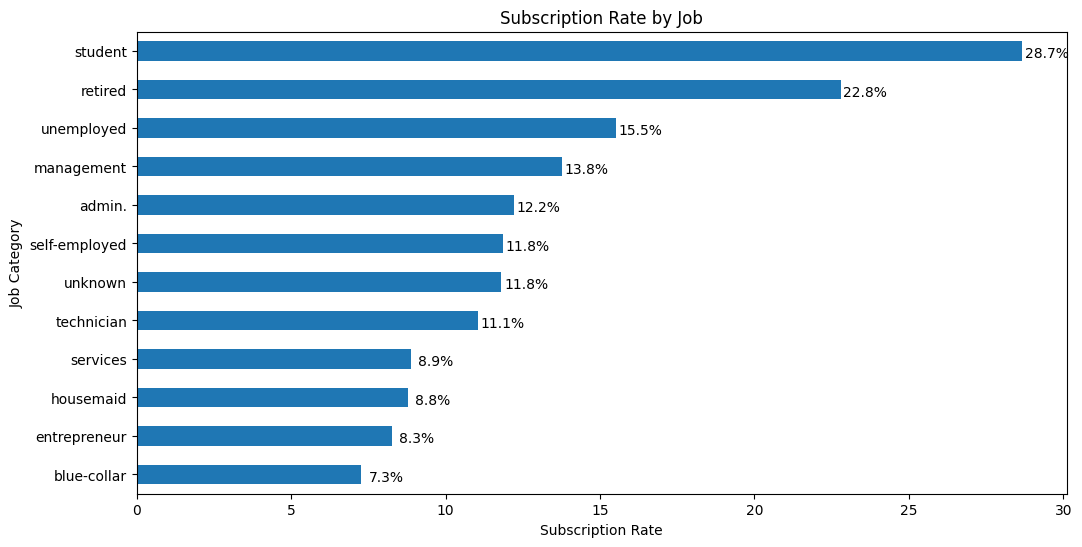

In [105]:
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))
                                                                               
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

In [151]:
df.education.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [153]:
count_education_response_pct = pd.crosstab(df['y'],df['education']).apply(lambda x: x/x.sum() * 100)
count_education_response_pct = count_education_response_pct.transpose()
count_education_response_pct

y,no,yes
education,,
primary,91.373522,8.626478
secondary,89.440565,10.559435
tertiary,84.993610,15.006390
unknown,86.429725,13.570275


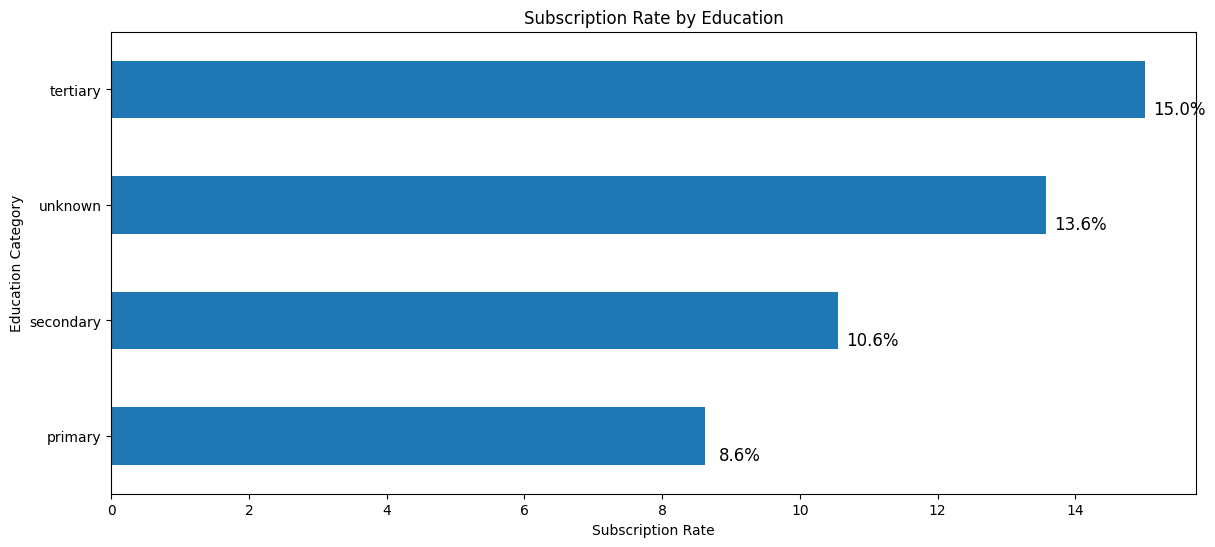

In [154]:
plot_education = count_education_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (14,6))
                                                                               
plt.title('Subscription Rate by Education')
plt.xlabel('Subscription Rate')
plt.ylabel('Education Category')

# Label each bar
for rec, label in zip(plot_education.patches,
                      count_education_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_education.text(rec.get_width()+0.5, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom',
                fontsize = 'large')

# Pre-processing the data

If we notice closely, there are 'unknown' values found in some of the features, so let's tackle that first

In [155]:
cols = [col for col in raw_data.columns]
col_missing =[]
for col in cols:
    if 'unknown' in raw_data[col].values:
        col_missing.append(col)

print('Columns with unknown values: ', col_missing)

Columns with unknown values:  ['job', 'education', 'contact', 'poutcome']


In [156]:
print('Unknown value counts: ')
for col in col_missing:
    print(col, ' - ', raw_data[raw_data[col].str.contains('unknown')][col].count())

Unknown value counts: 
job  -  288
education  -  1857
contact  -  13020
poutcome  -  36959


There are significantly amount of unkown entries in the data. 

In [160]:
print(raw_data.groupby(raw_data['job'])['job'].count(),'\n')
#we used this to print the result in the ascending order

job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: job, dtype: int64 



In [161]:
print(raw_data.groupby(raw_data['education'])['education'].count(),'\n')

education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: education, dtype: int64 



In [164]:
print(raw_data.groupby(raw_data['poutcome'])['poutcome'].count(),'\n')
# 'SeriesGroupBy' object has no attribute 'value_count'

poutcome
failure     4901
other       1840
success     1511
unknown    36959
Name: poutcome, dtype: int64 



In [165]:
print(raw_data.groupby(raw_data['contact'])['contact'].count(),'\n')

contact
cellular     29285
telephone     2906
unknown      13020
Name: contact, dtype: int64 



## Creating and transforming data

In [166]:
df = raw_data.copy()

In [167]:
df[['job','education','contact','poutcome']] = df[['job','education','contact','poutcome']].replace(['unknown'],'other')

In [168]:
df.poutcome.value_counts()

poutcome
other      38799
failure     4901
success     1511
Name: count, dtype: int64

In [169]:
# Custom binary encoding of binary output variables

df['default'] = np.where(df['default'].str.contains('yes'),1,0)
df['housing'] = np.where(df['housing'].str.contains('yes'),1,0)
df['loan'] = np.where(df['loan'].str.contains('yes'),1,0)
df['y'] = np.where(df['y'].str.contains('yes'),1,0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,balance_group
0,58,management,married,tertiary,0,2143,1,0,other,5,may,261,1,-1,0,other,0,50.0,average balance
1,44,technician,single,secondary,0,29,1,0,other,5,may,151,1,-1,0,other,0,40.0,low balance
2,33,entrepreneur,married,secondary,0,2,1,1,other,5,may,76,1,-1,0,other,0,30.0,low balance
3,47,blue-collar,married,other,0,1506,1,0,other,5,may,92,1,-1,0,other,0,40.0,average balance
4,33,other,single,other,0,1,0,0,other,5,may,198,1,-1,0,other,0,30.0,low balance


In [171]:
df.drop(['age_group','balance_group'], axis = 1, inplace = True)

Now, about the cateogorical varibale, I'd perfer to not go with the dummy variable, because there are so many categorical vairables, and in those variables, there are multiple categories. So, it is better if we go with LabelEnoder instead.

In [179]:
order={'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df=df.replace(order)

In [180]:
categorical = df.select_dtypes(include = ['object']).columns
categorical

Index(['job', 'marital', 'education', 'contact', 'poutcome'], dtype='object')

In [183]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for var in categorical:
    df[var] = label_encoder.fit_transform(df[var])

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,3,0,2143,1,0,1,5,5,261,1,-1,0,1,0
1,44,10,2,2,0,29,1,0,1,5,5,151,1,-1,0,1,0
2,33,2,1,2,0,2,1,1,1,5,5,76,1,-1,0,1,0
3,47,1,1,0,0,1506,1,0,1,5,5,92,1,-1,0,1,0
4,33,5,2,0,0,1,0,0,1,5,5,198,1,-1,0,1,0


In [184]:
df.month.unique()

array([ 5,  6,  7,  8, 10, 11, 12,  1,  2,  3,  4,  9], dtype=int64)

In [185]:
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,3,0,2143,1,0,1,5,5,4.35,1,-1,0,1,0
1,44,10,2,2,0,29,1,0,1,5,5,2.52,1,-1,0,1,0
2,33,2,1,2,0,2,1,1,1,5,5,1.27,1,-1,0,1,0
3,47,1,1,0,0,1506,1,0,1,5,5,1.53,1,-1,0,1,0
4,33,5,2,0,0,1,0,0,1,5,5,3.30,1,-1,0,1,0


## Standard Scaling

In [186]:
from sklearn.preprocessing import StandardScaler

In [187]:
df_std = df.copy()

In [189]:
col_name = ['balance','age','duration']
features = df_std[col_name]
rest = [col for col in df.columns if col not in col_name]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_std = pd.DataFrame(features, columns = col_name)
df_std[rest] = df[rest]
df_std.head()

,balance,age,duration,job,marital,education,default,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,0.256419,1.606965,0.011014,4,1,3,0,1,0,1,5,5,1,-1,0,1,0
1,-0.437895,0.288529,-0.415353,10,2,2,0,1,0,1,5,5,1,-1,0,1,0
2,-0.446762,-0.747384,-0.706586,2,1,2,0,1,1,1,5,5,1,-1,0,1,0
3,0.047205,0.571051,-0.646010,1,1,0,0,1,0,1,5,5,1,-1,0,1,0
4,-0.447091,-0.747384,-0.233623,5,2,0,0,0,0,1,5,5,1,-1,0,1,0


# Logistic Regression model and Accuracy

In [190]:
x = df_std.drop('y', axis = 1)
y = df_std.y

In [191]:
from sklearn.model_selection import train_test_split

In [192]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12)

In [193]:
print('Shape of x_train: ', x_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (36168, 16)
Shape of x_test:  (9043, 16)
Shape of y_train:  (36168,)
Shape of y_test:  (9043,)


In [194]:
from sklearn.linear_model import LogisticRegression

In [197]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score , recall_score , precision_score, f1_score

In [199]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [200]:
pred = lr.predict(x_test)

In [202]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7993
           1       0.65      0.32      0.42      1050

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043



In [203]:
print(confusion_matrix(y_test, pred))

[[7812  181]
 [ 718  332]]


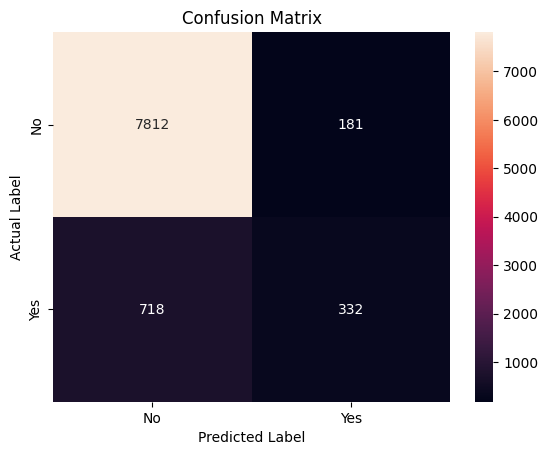

In [205]:
cm_df=confusion_matrix(y_test, pred)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [206]:
f1_score(y_test, pred)

0.4248240563019834

In [207]:
accuracy_score(y_test, pred)

0.9005860886873825

In [208]:
recall_score(y_test, pred)

0.3161904761904762

In [209]:
precision_score(y_test, pred)

0.6471734892787524

## The thresold level

In [211]:
y_pred_prob = lr.predict_proba(x_test)[0:10]
y_pred_prob

array([[0.9873286 , 0.0126714 ],
       [0.87126174, 0.12873826],
       [0.80411396, 0.19588604],
       [0.98766891, 0.01233109],
       [0.97327893, 0.02672107],
       [0.89698016, 0.10301984],
       [0.95056001, 0.04943999],
       [0.93137636, 0.06862364],
       [0.85530761, 0.14469239],
       [0.96406391, 0.03593609]])

In [212]:
# store the probabilities in dataframe

y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - No Subscription (0)', 'Prob of - Subscription (1)'])

y_pred_prob_df

,Prob of - No Subscription (0),Prob of - Subscription (1)
0,0.987329,0.012671
1,0.871262,0.128738
2,0.804114,0.195886
3,0.987669,0.012331
4,0.973279,0.026721
5,0.896980,0.103020
6,0.950560,0.049440
7,0.931376,0.068624
8,0.855308,0.144692
9,0.964064,0.035936


Text(0, 0.5, 'Frequency')

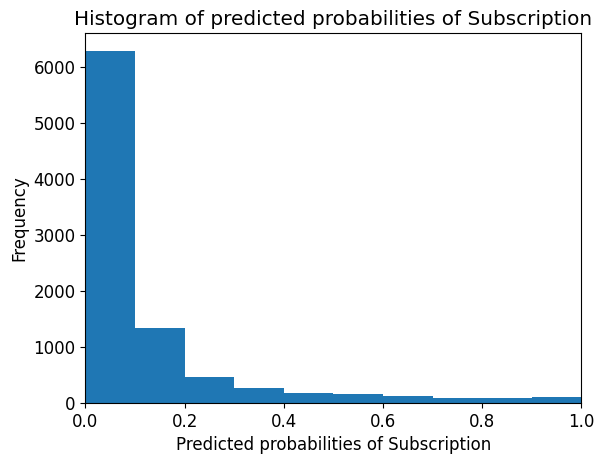

In [213]:
# store the predicted probabilities for class 1 - Probability of Subscription

y_pred1 = lr.predict_proba(x_test)[:, 1]
# plot histogram of predicted probabilities


# adjust the font size 
plt.rcParams['font.size'] = 12


# plot histogram with 10 bins
plt.hist(y_pred1, bins = 10)


# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of Subscription')


# set the x-axis limit
plt.xlim(0,1)


# set the title
plt.xlabel('Predicted probabilities of Subscription')
plt.ylabel('Frequency')

In [216]:
from sklearn.preprocessing import binarize

for i in range(1,5):
    
    cm1=0
    
    y_pred1 = lr.predict_proba(x_test)[:,1]
    
    y_pred1 = y_pred1.reshape(-1,1)
    
    y_pred2 = binarize(y_pred1, threshold=i/10)
       
    cm1 = confusion_matrix(y_test, y_pred2)
        
    print ('With',i/10,'threshold the Confusion Matrix is ','\n\n',cm1,'\n\n',
           
            'with',cm1[0,0]+cm1[1,1],'correct predictions, ', '\n\n', 
           
            cm1[0,1],'Type I errors( False Positives), ','\n\n',
           
            cm1[1,0],'Type II errors( False Negatives), ','\n\n',
           
               'Accuracy score: ', (accuracy_score(y_test, y_pred2)), '\n\n',
           
               'Sensitivity: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',
           
               'Specificity: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
                '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[6115 1878]
 [ 168  882]] 

 with 6997 correct predictions,  

 1878 Type I errors( False Positives),  

 168 Type II errors( False Negatives),  

 Accuracy score:  0.7737476501161119 

 Sensitivity:  0.84 

 Specificity:  0.7650444138621294 



With 0.2 threshold the Confusion Matrix is  

 [[7228  765]
 [ 396  654]] 

 with 7882 correct predictions,  

 765 Type I errors( False Positives),  

 396 Type II errors( False Negatives),  

 Accuracy score:  0.8716134026318699 

 Sensitivity:  0.6228571428571429 

 Specificity:  0.904291254847992 



With 0.3 threshold the Confusion Matrix is  

 [[7559  434]
 [ 527  523]] 

 with 8082 correct predictions,  

 434 Type I errors( False Positives),  

 527 Type II errors( False Negatives),  

 Accuracy score:  0.8937299568727193 

 Sensitivity:  0.4980952380952381 

 Specificity:  0.9457024896784687 



With 0.4 threshold the Confusion Matrix is  

 [[7714  279]
 [ 636  414]] 

 with 8128 correc

#### Comments
+ In binary problems, the threshold of 0.5 is used by default to convert predicted probabilities into class predictions.
+ Threshold can be adjusted to increase sensitivity or specificity.
+ Sensitivity and specificity have an inverse relationship. Increasing one would always decrease the other and vice versa.
+ We can see that increasing the threshold level results in increased accuracy.
+ Adjusting the threshold level should be one of the last step you do in the model-building process.

In [218]:
final_prediction = lr.predict_proba(x)[:,1]
fpr,tpr,thresholds=roc_curve(y,lr.predict_proba(x)[:,1])

accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
1192,0.490001,0.897215
1193,0.489881,0.897215
1191,0.490033,0.897193
1174,0.495933,0.897171
1173,0.496004,0.897149


If this was a use case for balaced dataset we would have gone with accuracy to select the optimal threshold value, otherwise it depends when data is imbalanced sometimes recall is more important than precision and sometimes the other way around and sometimes both are more important then we will go with F1-Score to select the optimal threshold value.

In [219]:
final_prediction = lr.predict_proba(x)[:,1]
fpr,tpr,thresholds=roc_curve(y,lr.predict_proba(x)[:,1])

f1_score_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    f1_score_ls.append(f1_score(y, y_pred))
    
f1_score_ls = pd.concat([pd.Series(thresholds), pd.Series(f1_score_ls)],axis=1)
f1_score_ls.columns = ['thresholds', 'f1_score']
f1_score_ls.sort_values(by='f1_score', ascending=False, inplace=True)
f1_score_ls.head()

,thresholds,f1_score
2977,0.217465,0.528292
2975,0.217749,0.528222
2976,0.217507,0.528212
2978,0.217247,0.528148
3293,0.195007,0.528103


In [224]:
pred = pred.reshape(-1,1)

In [225]:
y_pred = binarize(pred, threshold = 0.2)

In [226]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7993
           1       0.65      0.32      0.42      1050

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043



In [228]:
print(confusion_matrix(y_test, y_pred))

[[7812  181]
 [ 718  332]]


# SMOTE

In [230]:
# import imblearn library and resample the original data using SMOTE technique
#from sklearn.neighbors import DistanceMetric
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(x_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_smote))

Original dataset shape Counter({0: 31929, 1: 4239})
Resampled dataset shape Counter({0: 31929, 1: 31929})


In [231]:
# training a Logistic Regression model on SMOTE data

lr_smote = LogisticRegression()
lr_smote.fit(X_smote, y_smote)

LogisticRegression()

In [232]:
pred_sm = lr_smote.predict(x_test)

In [233]:
print(confusion_matrix(y_test, pred_sm))

[[6707 1286]
 [ 281  769]]


In [234]:
print(classification_report(y_test, pred_sm))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7993
           1       0.37      0.73      0.50      1050

    accuracy                           0.83      9043
   macro avg       0.67      0.79      0.70      9043
weighted avg       0.89      0.83      0.85      9043



Comparing it with our original imbalanced data result

In [235]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7993
           1       0.65      0.32      0.42      1050

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043



# Conclusion

After comparing the result of the various models, I choose to use the model without SMOTE, and threshold 0.2 as my final model.